In [25]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem
from rdkit.Chem.Draw import rdMolDraw2D, MolDraw2DCairo, SimilarityMaps
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import zipfile
import io
import os
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from IPython.display import SVG, display, HTML
import matplotlib.pyplot as plt
from collections import defaultdict

## Data

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from a zip file and compute Morgan fingerprints.

    Args:
        file_path: The path to the zip file containing the data.

    Returns:
        A data frame containing the loaded data and computed fingerprints.

    Raises:
        ValueError: If the zip file does not contain any files.
    """
    with zipfile.ZipFile(file_path, 'r') as z:
        filename = z.namelist()[0]
        with z.open(filename) as f:
            data = io.BytesIO(f.read())
    df = PandasTools.LoadSDF(data)
    df.activity = df.activity.astype(int)
    df['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df.ROMol)]
    return df

train_path = os.path.join("ibenchmark/Datasets/N_train_lbl.zip")
df_train = load_data(train_path)

test_path = os.path.join("ibenchmark/Datasets/N_test_lbl.zip")
df_test = load_data(test_path)

# Training data
train_X = np.asarray(list(df_train.fp.values))
train_y = df_train.activity.values

# Test data
test_X = np.asarray(list(df_test.fp.values))
test_y = df_test.activity.values

  0%|          | 0/6995 [00:00<?, ?it/s]

  0%|          | 0/2999 [00:00<?, ?it/s]

## Training the ML model

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters:  {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 9}


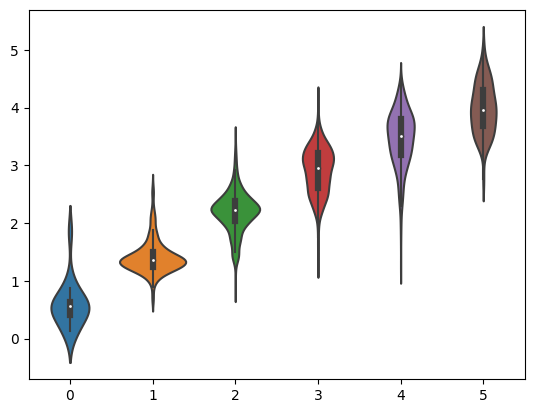

In [6]:
# Define the hyperparameters and their possible values
params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 1],
#     'n_estimators': [50, 100, 200],
#     'subsample': [0.5, 0.8, 1],
#     'colsample_bytree': [0.5, 0.8, 1],
    'gamma': [0, 0.1, 0.5]
}

# Create an instance of the XGBRegressor
xgb = XGBRegressor()

# Create an instance of GridSearchCV with 5-fold cross validation
grid = GridSearchCV(xgb, params, cv=5, verbose=2, n_jobs=-1)


# Fit the grid search to the training data
grid.fit(train_X, train_y)

# Print the best hyperparameters found by the grid search
print("Best hyperparameters: ", grid.best_params_)

# Use the best model to make predictions on the test data
test_pred = grid.predict(test_X)

# Visualize the predictions using a violin plot
sns.violinplot(x=test_y, y=test_pred);

## Draw molecules

In [46]:
def draw_molecule(molecule, width=500, height=500, add_atom_indices=True):
    """Draws a 2D representation of a given molecule using RDKit and returns an SVG image.

    Args:
        molecule (rdkit.Chem.Mol): The molecule to be drawn.
        width (int): The width of the SVG image (default=500).
        height (int): The height of the SVG image (default=500).
        add_atom_indices (bool): Whether to add atom indices to the drawing (default=True).

    Returns:
        SVG: The SVG image of the molecule.
    """
    try:
        # Create a 2D drawing object with specified dimensions
        d2d = rdMolDraw2D.MolDraw2DSVG(width, height)

        # Add atom indices to the drawing options if required
        if add_atom_indices:
            d2d.drawOptions().addAtomIndices = True

        # Draw the molecule using the 2D drawing object
        d2d.DrawMolecule(molecule)

        # Finish the drawing process
        d2d.FinishDrawing()

        # Convert the drawing object to an SVG image and return it
        return SVG(d2d.GetDrawingText())

    except Exception as e:
        # Handle any exceptions and return an error message
        return f"Error drawing molecule: {str(e)}"


def display_molecules_in_table(num_rows, num_cols):
    """ Displays a table of chemical molecules in an HTML format.
    
    Args:
        num_rows (int): Number of rows in the table.
        num_cols (int): Number of columns in the table.

    Returns:
        None
    """
    # Create an HTML table with the specified number of rows and columns
    table = "<table>"
    for i in range(num_rows):
        table += "<tr>"
        for j in range(num_cols):
            # Get the SVG image for the current molecule
            if i * num_cols + j < num_rows*num_cols:
                example_mol = Chem.Mol(df_train.ROMol.values[i * num_cols + j])
                svg_image = draw_molecule(example_mol)
            else:
                svg_image = SVG()

            # Add the SVG image as a table cell
            table += f"<td>{svg_image.data}</td>"
        table += "</tr>"
    table += "</table>"

    # Display the HTML table
    display(HTML(table))

display_molecules_in_table(num_rows=3, num_cols=3)

## Similarity maps

,,
,,
,,

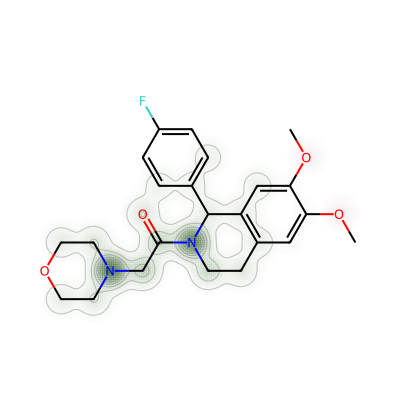
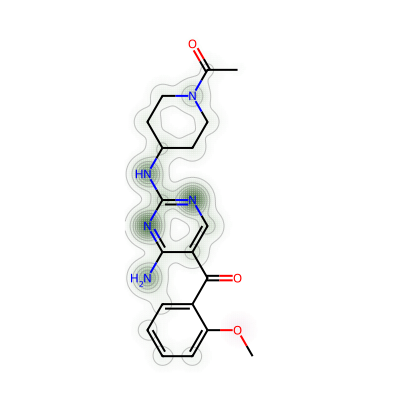
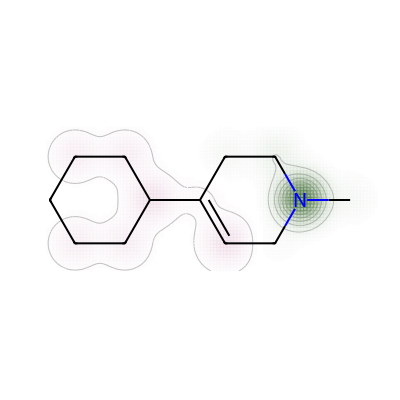
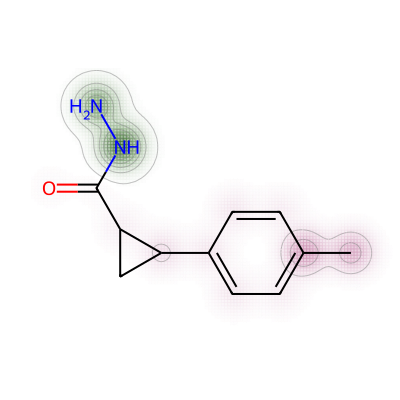
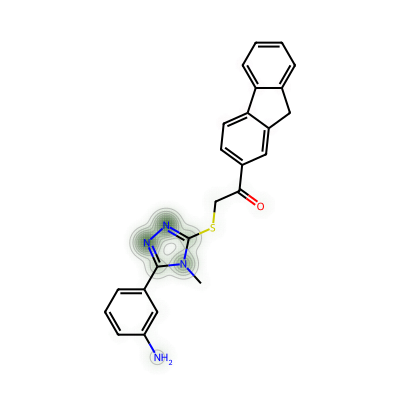
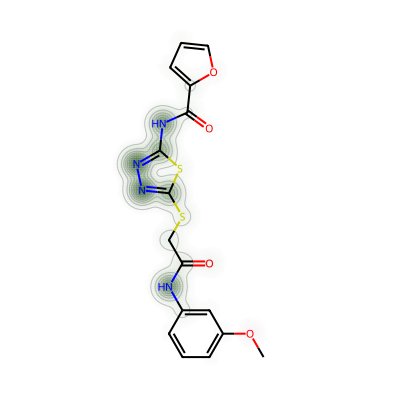
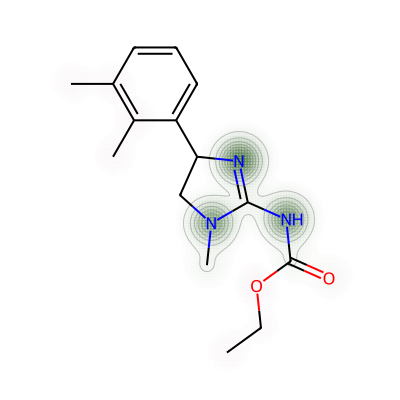
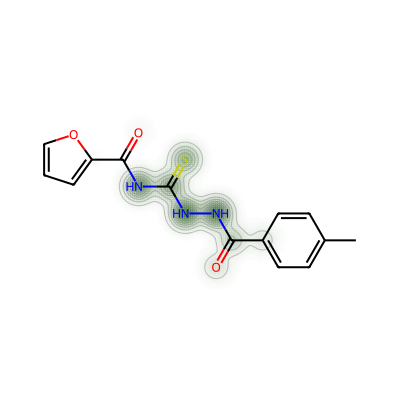
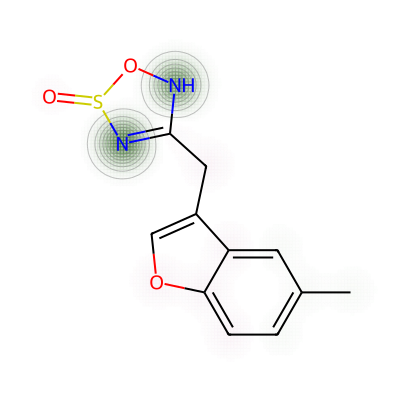

In [47]:
def show_png(data):
    """Converts byte data to PNG image and returns its byte data.

    Args:
        data: A byte object containing image data.

    Returns:
        A byte object containing PNG image data.
    """
    bio = io.BytesIO(data)
    img = Image.open(bio)
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    return img_byte_arr.getvalue()

def get_pred(fp, pred_function):
    """Calls the provided prediction function with the input fingerprint array and returns the prediction value.

    Args:
        fp: The input fingerprint.
        pred_function: A function that takes in a fingerprint array and returns a prediction value.

    Returns:
        A float value containing the prediction result.
    """
    fp = np.array([list(fp)])
    return pred_function(fp)[0]

def get_similarity_map_image(mol, model):
    """Generates a 2D similarity map for the provided molecule and model, and returns a PNG image of the map.

    Args:
        mol: RDKit molecule object.
        model: A trained machine learning model.

    Returns:
        A byte object containing PNG image data.
    """
    d = MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapForModel(mol, 
                                            SimilarityMaps.GetMorganFingerprint, 
                                            lambda x : get_pred(x, model.predict), 
                                            draw2d=d)
    d.FinishDrawing()
    img_data = d.GetDrawingText()
    return show_png(img_data)



def display_similarity_molecules_in_table(num_rows, num_cols):
    """ Displays a table of chemical molecules in an HTML format.
    
    Args:
        num_rows (int): Number of rows in the table.
        num_cols (int): Number of columns in the table.

    Returns:
        None
    """
    # Create an HTML table with the specified number of rows and columns
    table = "<table>"
    for i in range(num_rows):
        table += "<tr>"
        for j in range(num_cols):
            # Get the PNG image for the current molecule
            if i * num_cols + j < num_rows*num_cols:
                example_mol = df_train.ROMol.values[i * num_cols + j]
                image = get_similarity_map_image(example_mol, grid)

            # Add the PNG image as a table cell
            table += f"<td><img src='data:image/png;base64,{base64.b64encode(image).decode('utf-8')}'></td>"
        table += "</tr>"
    table += "</table>"

    # Display the HTML table
    display(HTML(table))


display_similarity_molecules_in_table(num_rows=3, num_cols=3)

## Top-n score

In [67]:
def calculate_top_n_score(ref, pred):
    """ Calculates the 'top n' score between the ground truth and predicted atomic weights.
    
    Args:
        ref: np.array of binary labels for whether an atom is important or not (ground truth).
        pred: np.array of predicted atomic weights for each atom.
    
    Returns:
        The 'top n' score.
    """
    n = int(np.sum(ref))
    
    # Indices of the top n atoms in ground truth
    top_ref_idx = ref.argsort()[-n:][::-1] 
    
    # Indices of the top n atoms in predicted weights
    top_pred_idx = pred.argsort()[-n:][::-1]  
    
    # Number of common atoms in the top n
    num_common = len(set(top_ref_idx).intersection(set(top_pred_idx)))  
    
    # Ratio of correctly ranked atoms in the top n to total number of atoms
    return num_common / float(n) 

# Calculate AUC and top n score for the first 100 test molecules
auc_scores = []
top_n_scores = []
top_n_lt_1 = []
for idx, (mol, label) in tqdm(enumerate(df_test[["ROMol","lbls"]].head(100).values), total=100):
    
    # Calculate atomic weights for the molecule
    atomic_weights = SimilarityMaps.GetAtomicWeightsForModel(mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, grid.predict))
    
    # Calculate AUC and top n score if the molecule has a non-"NA" label
    if label != "NA":
        label_array = np.fromstring(label, sep=",", dtype=int)
        auc_scores.append(roc_auc_score(label_array, atomic_weights))
        top_n_score = calculate_top_n_score(label_array, np.array(atomic_weights))
        top_n_scores.append(top_n_score)
        if top_n_score < 1:
            top_n_lt_1.append((idx, top_n_score))
        
# print mean AUC and top n score
print(f"Mean AUC: {np.mean(auc_scores):.2}")
print(f"Mean top_n = {np.mean(top_n_score):.2f}")

df_lt_1 = pd.DataFrame(top_n_lt_1,columns=["Row","Top_n_score"])
mistaken_rows = df_lt_1["Row"].values
df_lt_1

  0%|          | 0/100 [00:00<?, ?it/s]

Mean AUC: 0.99
Mean top_n = 1.00


,Row,Top_n_score
0,7,0.500000
1,10,0.500000
2,21,0.666667
3,27,0.500000
4,29,0.800000
5,33,0.666667
6,44,0.666667
7,59,0.666667
8,66,0.500000
9,67,0.500000


## Debugging

In [77]:
def debug_row(df, idx, mdl):
    # Set highlight colors
    red = (1, 0, 0)
    blue = (0, 0, 1)

    # Get molecule and label
    mol = Chem.Mol(df.loc[[idx]].ROMol.values[0])
    label = df.loc[idx].lbls
    label_array = np.fromstring(label, sep=",", dtype=int)
    n = int(sum(label_array))

    # Get atomic weights and top indices
    aw = np.array(SimilarityMaps.GetAtomicWeightsForModel(
        mol, 
        SimilarityMaps.GetMorganFingerprint,
        lambda x: get_pred(x, mdl.predict)))
    top_idx = aw.argsort()[-n:][::-1].astype(int)

    # Set the drawing options
    d2d = rdMolDraw2D.MolDraw2DSVG(350, 300)
    dos = d2d.drawOptions()
    dos.atomHighlightsAreCircles = True
    dos.fillHighlights = False

    # Set the highlight colors for the top N predicted and labeled atoms
    top_dict = defaultdict(list)
    highlight_rads = {}
    for t in top_idx:
        top_dict[int(t)].append(red)
    for a in label_array.argsort()[-n:]:
        top_dict[int(a)].append(blue)

    # Set the radii for the highlight circles
    for k, v in top_dict.items():
        highlight_rads[int(k)] = 0.6

    # Draw the molecule with highlights and return the SVG
    d2d.DrawMoleculeWithHighlights(mol, " ", dict(top_dict), {}, highlight_rads, {})
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

def display_debugging_in_table(num_rows, num_cols):
    """ Displays a debugging table of chemical molecules in an HTML format.
    
    Args:
        num_rows (int): Number of rows in the table.
        num_cols (int): Number of columns in the table.

    Returns:
        None
    """
    # Create an HTML table with the specified number of rows and columns
    table = "<table>"
    for i in range(num_rows):
        table += "<tr>"
        for j in range(num_cols):
            # Get the SVG image for the current molecule
            if i * num_cols + j < num_rows*num_cols:
                svg_image = debug_row(df_test,mistaken_rows[i * num_cols + j], grid)
            else:
                svg_image = SVG()

            # Add the SVG image as a table cell
            table += f"<td>{svg_image.data}</td>"
        table += "</tr>"
    table += "</table>"

    # Display the HTML table
    display(HTML(table))

display_debugging_in_table(num_rows=3, num_cols=3)